In [2]:
import os
from kbmod.image_info import ImageInfoSet, ImageInfo
from glob import glob
from astropy.io import fits
import numpy as np
from astropy.time import Time
import kbmod.search as kb
import pandas as pd
from kbmod.run_search import run_search
#from parsers.AtlasParser import AtlasParser

In [3]:
from datetime import datetime, timedelta
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import subprocess
import cv2

import warnings
from astropy.io.fits.verify import VerifyWarning
from astropy.wcs import FITSFixedWarning

# Ignore specific warnings
warnings.simplefilter('ignore', VerifyWarning)
warnings.simplefilter('ignore', FITSFixedWarning)

class ATLASParser():
    
    def __init__(self, working_path, image_type='science', crop_params=None, align=True, grow_mask=True):
        
        # paths
        self.working_path = working_path
        if not os.path.exists(self.working_path): os.makedirs(self.working_path)
        if not os.path.exists(os.path.join(self.working_path, 'ori/')): os.makedirs(os.path.join(self.working_path, 'ori/'))
        self.ori_image_path = os.path.join(self.working_path, 'ori/')
        if not os.path.exists(os.path.join(self.working_path, 'prep_images/')): os.makedirs(os.path.join(self.working_path, 'prep_images/'))
        self.kbmod_image_path = os.path.join(self.working_path, 'prep_images/')
        if not os.path.exists(os.path.join(self.working_path, 'warped/')): os.makedirs(os.path.join(self.working_path, 'warped/'))
        self.warped_image_path = os.path.join(self.working_path, 'warped/')

        # config parameters
        self.rebinning_factor = 8
        self.image_type = image_type
        self.crop_params = crop_params
        self.grow_mask = grow_mask


    def oversample_array(self, array):
        rows = np.repeat(array, self.rebinning_factor, axis=0)
        return np.repeat(rows, self.rebinning_factor, axis=1)      
    
    
    def correct_header(self, header, new_header):
        header['CTYPE1'] = 'RA---TAN-SIP'
        header['CTYPE2'] = 'DEC--TAN-SIP'
        header['OBS-LAT'] = header['SITELAT']
        header['OBS-LONG'] = header['SITELONG']
        header['OBS-ELEV'] = header['SITEELEV']
        if header['OBSID'][:2] == '01': header['OBSERVAT'] = 'T05'
        elif header['OBSID'][:2] == '02': header['OBSERVAT'] = 'T08'
        elif header['OBSID'][:2] == '03': header['OBSERVAT'] = 'W68'
        elif header['OBSID'][:2] == '04': header['OBSERVAT'] = 'M22'
        header['DATE-AVG'] = (datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S%z') +
                              timedelta(seconds=header['EXPTIME']/2)).strftime('%Y-%m-%dT%H:%M:%S')
        header['MJD-AVG'] = header['MJD-OBS'] + header['EXPTIME']/2/86400
        header["IDNUM"] = header['OBSID']
        header['PIXSCALE'] = header['RP_ASCL']
        header['PSF'] = header['FWHM']/2.355


        # for key in list(header.keys()):
        #     if key.startswith('PV'): header.remove(key)

        # wcs_keywords = ['CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 
        #                 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'RADECSYS', 'EQUINOX', 'LONPOLE', 'LATPOLE']
        # header['RADESYSa'] = header['RADECSYS']
        # del header['RADECSYS']
        # for keyword in wcs_keywords: header[keyword] = new_header[keyword]
        # for i in range(1, header['NAXIS']+1):
        #     for j in range(1, header['NAXIS']+1):
        #         header.remove(f'PC{i}_{j}', ignore_missing=True)
        #         header.remove(f'CD{i}_{j}', ignore_missing=True)

        # for i in range(1, header['NAXIS']+1):
        #     for j in range(1, 21):
        #         header.remove(f'PV{i}_{j}', ignore_missing=True)

        new_header['NAXIS'] = 2
        del new_header['NAXIS3']

        for keyword in new_header.keys():
            if keyword != 'COMMENT': header[keyword] = new_header[keyword]

        return header
    
    def get_image(self, file, ra=None, dec=None):

        # warp image
        if self.image_type == 'diff':
            ori = file.replace('fits.fz', 'diff.fz')
        else:
            ori = file
        var = file
        res_file = os.path.join(self.warped_image_path, os.path.basename(file).replace('.fits.fz', '.fits'))
        
        # warp image
        self.warp(ori, var, res_file)

        # load image
        print('Getting warped image', end="\r")
        with fits.open(res_file, output_verify='silentfix') as hdul:
            data = hdul[0].data
            new_header = hdul[0].header
        img = data[0,:,:]
        var = data[1,:,:]

        print('Correcting header', end="\r")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            header = fits.getheader(file, 1)
        header = self.correct_header(header, new_header)

        print('masking image', end="\r")
        if self.grow_mask: mask =  self.create_mask_conv(img.astype(np.double), header['FWHM'])
        else: mask = self.create_mask(img)
        
        return img.astype(np.float32), header, mask, var.astype(np.float32)

    def load_images(self, im_list, save=True):

        print("---------------------------------------")
        print("Loading Images")
        print("---------------------------------------")

        img_info = ImageInfoSet()
        images = []
        visit_times = []
        # del_keys = ['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND', 'HISTORY', 'COMMENT']
        ra, dec = None, None
        t0 = datetime.utcnow()

        for i,im in enumerate(im_list):

            print(f'{i+1}/{len(im_list)}: {im}')

            sci, header, mask, var = self.get_image(im, ra, dec)
            if i == 0:
                ra, dec = header['RA'], header['DEC']
                self.header0 = header

            # for key in h_wcs.keys():
            #     if key not in del_keys: header[key] = h_wcs[key]
            # header['NAXIS1'] = sci.shape[0]
            # header['NAXIS2'] = sci.shape[1]

            header_info = ImageInfo()
            header_info.populate_from_header(header)
            time_stamp = header['MJD-AVG']
            psf = kb.psf(header['PSF'])

            img = kb.layered_image(kb.raw_image(sci), 
                                    kb.raw_image(var),
                                    kb.raw_image(mask),
                                    time_stamp, psf)
            images.append(img)
            visit_times.append(time_stamp)
            img_info.append(header_info)

            print('Image added to stack', end="\r")

            if save:
                image = [fits.PrimaryHDU(sci, header), fits.PrimaryHDU(mask, header), fits.PrimaryHDU(var, header)]
                if self.image_type == 'diff': lab = [os.path.basename(im).replace('fits.fz','diff.fits')]
                else: lab = [os.path.basename(im).replace('fits.fz','sci.fits')]

                lab += [os.path.basename(im).replace('fits.fz','mask.fits'),
                        os.path.basename(im).replace('fits.fz','var.fits')]
                        
                for h in range(len(image)):
                    image[h].writeto(os.path.join(self.kbmod_image_path, lab[h]), overwrite=True, output_verify='silentfix')

        stack = kb.image_stack(images)

        # Create a list of visit times and visit times shifted to 0.0.
        img_info.set_times_mjd(np.array(visit_times))
        times = img_info.get_zero_shifted_times()
        stack.set_times(times)
        te = (datetime.utcnow() - t0).total_seconds()
        print("Stack created, time elapsed: %.1f s" % te, end="\r")

        self.stack = stack
        self.img_info = img_info
        return stack, img_info


    def warp(self, image_file, var_file, res_file):

        print('Warping image', end="\r")

        # get center coordinates
        center_ra = self.crop_params['center_coords'][0]
        center_dec = self.crop_params['center_coords'][1]
        nx = self.crop_params['crop_size']
        ny = self.crop_params['crop_size']

        # executable path
        warpsky_path = "./parsers/warpsky"
        command = [warpsky_path, image_file, res_file, '-var', var_file,'-r0', str(center_ra), '-d0', str(center_dec), '-cx', '0', '-cy', '0']
        if nx is not None:
            command += ['-nx', str(nx), '-ny', str(ny)]

        result = subprocess.run(command, capture_output=True, text=True)

    def create_mask(self, img):
        mask = np.zeros(img.shape)
        mask[img < -1e3] = 1
        return mask
    
    def create_mask_conv(self, image, fwhm):

        filter_size = int(5 * fwhm)
        if filter_size % 2 == 0:
            filter_size += 1

        mean_image = cv2.boxFilter(image, -1, (filter_size, filter_size))
        squared_img = cv2.boxFilter(image**2, -1, (filter_size, filter_size))
        std_dev_image = np.sqrt(squared_img - mean_image**2)

        sky_std_med = np.median(std_dev_image)

        mask_for_std = (std_dev_image < sky_std_med*1.25) & (std_dev_image > sky_std_med*0.75)
        sky_std_std = np.std(std_dev_image[mask_for_std])

        mask = (std_dev_image > sky_std_med + 5*sky_std_std) | (mean_image < -1e3)

        sky_med = np.median(mean_image[~mask])
        sky_std = np.std(mean_image[~mask])

        mask = (mean_image < sky_med + 5*sky_std) & mask

        time = datetime.now()
        mask = (mask.astype(np.uint8) * 255) 
        mask_blurred = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3)
        mask = np.where(mask_blurred > 127, 255, 0).astype(np.uint8)
        #kernel = np.ones((3, 3), np.uint8)
        #mask = cv2.dilate(mask, np.ones((1, 1), np.uint8))

        return mask

    @staticmethod
    def crop_image(im, header, coords, size=1000):
        wcs = WCS(header)
        center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
        center_px = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        cutout = Cutout2D(im, center_px, size*u.pixel, wcs=wcs)
        cropped_data = cutout.data
        cropped_wcs = cutout.wcs
        header.update(cropped_wcs.to_header())
        return cropped_data, header
    

    @staticmethod
    def center(im, header, coords, size=1000):
        if type(coords[0]) == float:
            wcs = WCS(header)
            center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
            coords = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        return im[int(coords[0]-size/2):int(coords[0]+size/2), int(coords[1]-size/2):int(coords[1]+size/2)]


    @staticmethod
    def astrometrize(sources, im_shape, scale):
        ast = AstrometryNet()
        image_width = im_shape[0]
        image_height = im_shape[1]
        h_wcs = ast.solve_from_source_list(sources[:,0], sources[:,1],
                                            image_width, image_height,
                                            tweak_order=3, solve_timeout=180,
                                            scale_est = scale, scale_err = scale*0.1,
                                            scale_units = 'arcsecperpix')
        return h_wcs
    
    @staticmethod
    def arcsecmin_to_pxday(arcsecmin, pxsize=1.86):
        return arcsecmin/pxsize*60*24

    @staticmethod
    def pxday_to_arcsecmin(pxday, pxsize=1.86):
        return pxday*pxsize/60/24
    

    @staticmethod
    def dyn_avgstd(valuenew, nold, avgold, stdold):
        nnew = nold + (valuenew != 0).astype(np.int)
        if np.sum(nold) == 0:
            avgnew = np.asarray(valuenew, dtype=np.double)
            stdnew = np.zeros_like(valuenew, dtype=np.double)
        else:
            avgnew = avgold + (valuenew - avgold) / nnew
            stdnew = np.sqrt(
                nold/nnew * stdold**2 +
                (valuenew - avgnew) * (valuenew - avgold) / nnew
                )
        return nnew, avgnew, stdnew


-- --
# GET ATLAS FILES
-- --

In [6]:
pointing_list_path = 'lab/pointing_files/'

df_01a = pd.read_csv(os.path.join(pointing_list_path, '01a.list.txt'), delim_whitespace=True)
df_02a = pd.read_csv(os.path.join(pointing_list_path, '02a.list.txt'), delim_whitespace=True)
df_03a = pd.read_csv(os.path.join(pointing_list_path, '03a.list.txt'), delim_whitespace=True)
df_04a = pd.read_csv(os.path.join(pointing_list_path, '04a.list.txt'), delim_whitespace=True)


# Concatenate the dataframes
df = pd.concat([df_01a, df_02a, df_03a, df_04a], ignore_index=True)

# Mapping of observatory codes to names
observatory_mapping = {
    '01': 'T05',
    '02': 'T08',
    '03': 'W68',
    '04': 'M22'
}

df = df.loc[df.zp_mag != 0]

# # Extract the observatory code from the expname column and map it to its name



In [18]:
def filter_images_containing_area(df, center_ra_str, center_dec_str,
                                  center_mjd, max_sep_mjd,
                                  crop_area_px, full_image_px=10000, px_scale=1.86):
    """
    Filters the dataframe to select images that fully contain a specific sky area.
    
    Args:
    - df (DataFrame): The input dataframe with pointings data.
    - center_ra_str (str): Right ascension of the sky area's center in "hh mm ss" format.
    - center_dec_str (str): Declination of the sky area's center in "deg mm ss" format.
    - center_mjd (float): Modified Julian Date of the sky area's center.
    - max_sep_mjd (float): Maximum separation from the sky area's center in days.
    - crop_area_px (int): Cropping square area in pixels.
    - full_image_px (int, optional): Full image side length in pixels. Default is 10000.
    - px_scale (float, optional): Pixel scale in arcseconds per pixel. Default is 1.86.
    
    Returns:
    - DataFrame: Filtered dataframe.
    """
    
    # Convert center RA and Dec from string format to decimal degrees
    ra_h, ra_m, ra_s = np.array(center_ra_str.split()).astype(float)
    dec_d, dec_m, dec_s = np.array(center_dec_str.split()).astype(float)
    center_ra = (ra_h + ra_m/60 + ra_s/3600) * 15
    if dec_d < 0: center_dec = dec_d - dec_m/60 - dec_s/3600
    else: center_dec = dec_d + dec_m/60 + dec_s/3600

    
    # Convert full image and crop area in pixels to degrees
    full_image_side_length_deg = (full_image_px * px_scale) / 3600.0
    crop_side_length_deg = (crop_area_px * px_scale) / 3600.0
    
    # Filter the dataframe
    df['long_side'] = np.maximum(np.abs(df['ra_deg'] - center_ra), np.abs(df['dec_deg'] - center_dec))
    filtered_df = df[df['long_side'] + crop_side_length_deg/2 < full_image_side_length_deg/2]

    if center_mjd is not None:
        filtered_df = filtered_df[
            (filtered_df['mjd0'] <= center_mjd + max_sep_mjd) &
            (filtered_df['mjd0'] >= center_mjd - max_sep_mjd) 
        ]

    filtered_df['observatory'] = filtered_df['expname'].str[:2].map(observatory_mapping)

    return filtered_df




In [8]:
def query_ast_pos(target, df):

    grouped_data = df.groupby(['observatory'])['mjdmid'].agg(list).reset_index()
    result_df = pd.DataFrame(columns=['date', 'observatory', 'object', 'RA', 'DEC'])

    dates = []
    observatories = []
    objects = []
    ras = []
    decs = []
    for idx, row in grouped_data.iterrows():
        obs_id = row['observatory']
        mjds = np.array(row['mjdmid']).astype(np.float32)

        obj = Horizons(id=target, location=obs_id, epochs=mjds)
        eph = obj.ephemerides()

        dates.extend(eph['datetime_str'])
        observatories.extend([obs_id] * len(eph))
        objects.extend([target] * len(eph))
        ras.extend(eph['RA'])
        decs.extend(eph['DEC'])

    return pd.DataFrame({
        'date': pd.to_datetime(dates),
        'observatory': observatories,
        'object': objects,
        'RA': ras,
        'Dec': decs
        }).sort_values(by=['date']).reset_index(drop=True)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astroquery.jplhorizons import Horizons

def plot_frames_and_crop_area(df, center_ra_str, center_dec_str, crop_area_px, ast_df, full_image_px=10000, px_scale=1.86):
    """
    Plots the full frames with different colors for each telescope and the desired cropped area as a shaded red square.
    
    Args:
    - df (DataFrame): Filtered dataframe with pointings data.
    - center_ra_str (str): Right ascension of the sky area's center in "hh mm ss" format.
    - center_dec_str (str): Declination of the sky area's center in "deg mm ss" format.
    - crop_area_px (int): Cropping square area in pixels.
    - ast_df (DataFrame): DataFrame with asteroid positions.
    - full_image_px (int, optional): Full image side length in pixels. Default is 10000.
    - px_scale (float, optional): Pixel scale in arcseconds per pixel. Default is 1.86.
    """

    # Convert center RA and Dec from string format to decimal degrees
    ra_h, ra_m, ra_s = np.array(center_ra_str.split()).astype(float)
    dec_d, dec_m, dec_s = np.array(center_dec_str.split()).astype(float)
    center_ra = (ra_h + ra_m/60 + ra_s/3600) * 15
    if dec_d < 0: center_dec = dec_d - dec_m/60 - dec_s/3600
    else: center_dec = dec_d + dec_m/60 + dec_s/3600

    # Define the side length of the square in degrees for 10k x 10k pixels
    side_length = full_image_px * px_scale / 3600
    crop_area_deg = crop_area_px * px_scale / 3600

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_aspect('equal', adjustable='datalim')
    
    # Plot the cropped area as a red square
    rect = patches.Rectangle((center_ra - crop_area_deg/2, center_dec - crop_area_deg/2), crop_area_deg, crop_area_deg,
                             linewidth=1, edgecolor='r', facecolor='r', alpha=0.3)
    ax.add_patch(rect)
    ax.plot(center_ra, center_dec, 'rx', label="Target", markersize=10)

    observatory_color_mapping = {
    'T05': 'blue',
    'T08': 'green',
    'W68': 'orange',
    'M22': 'purple'}


    # Plot each pointing as a square
    obs = []
    for ra, dec, observatory in zip(df['ra_deg'], df['dec_deg'], df['observatory']):
        if observatory not in obs:
            obs.append(observatory)
            label=observatory
        else: label=None
        rect = patches.Rectangle((ra - side_length/2, dec - side_length/2), side_length, side_length, label=label,
                                linewidth=1, edgecolor=observatory_color_mapping[observatory], facecolor='none')
        ax.add_patch(rect)


    # Plot trajectory of the asteroid
    if ast_df is not None: ax.plot(ast_df['RA'], ast_df['Dec'], 'k.', label=ast_df['object'].iloc[0], markersize=2.5)

    # Plot zoomed-in area around the asteroid
    axins = ax.inset_axes([0.06, 0.035, 0.3, 0.3])
    axins.set_aspect('equal', adjustable='datalim')
    axins.set_xlim(center_ra - crop_area_deg/2, center_ra + crop_area_deg/2)
    axins.set_ylim(center_dec - crop_area_deg/2, center_dec + crop_area_deg/2)
    if ast_df is not None: axins.plot(ast_df['RA'], ast_df['Dec'], 'k.', markersize=3)
    # axins.set_xticklabels('')
    # axins.set_yticklabels('')
    

    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.legend(frameon=False)
    ax.grid(False)
    plt.show()

In [86]:
a = 'k9442K02GG6G  C2000 05 05.30238512 24 18.62 +01 15 50.0                 ~1vV9645'
a = 'k9442K02GG6G @C2014 04 04.43905 14 25 15.181-15 07 40.96         21.4 rq~1XPo568'

date = a[15:32]
ra = a[32:44]
dec = a[44:56]
print(date, ra, dec)

2014 04 04.43905  14 25 15.181 -15 07 40.96


In [191]:
target = 'Makemake'
center_ra_str = '13 13 19.5'#'18 30 54.9'#'09 16 47.2'  
center_dec_str = '23 00 23'#'10 21 41'#'14 22 49'
center_mjd = 59680
max_sep_mjd = 30#15
crop_area_px = 2*1024
pxscale = 1.86

filtered_df = filter_images_containing_area(df, center_ra_str, center_dec_str,
                                            center_mjd, max_sep_mjd, crop_area_px)
                                            
print(f'Available observing fields: {len(filtered_df)}')
print(f'Image size: {crop_area_px} x {crop_area_px} px (%.2f x %.2f deg)' % (crop_area_px*pxscale/3600, crop_area_px*pxscale/3600))

filtered_df.head()


Available observing fields: 52
Image size: 2048 x 2048 px (1.06 x 1.06 deg)


,expname,mjd0,ra_deg,dec_deg,fwhm_px,zp_mag,mag5sig,pa_deg,mjdmid,object,long_side,observatory
1202501,01a59651o0572o,59651.487089,199.76352,24.89026,2.7945,22.216,19.13,1.026,59651.487263,SF200N25,1.883871,T05
1202505,01a59651o0576o,59651.489002,199.75224,24.91151,2.6529,22.214,19.24,1.028,59651.489175,SF200N25,1.905121,T05
1202530,01a59651o0601o,59651.501521,199.78553,24.87125,2.6550,22.218,19.21,1.037,59651.501695,SF200N25,1.864861,T05
1202541,01a59651o0612o,59651.506635,199.79550,24.93366,2.7444,22.219,19.16,1.041,59651.506808,SF200N25,1.927271,T05
1216350,01a59672o0395o,59672.399259,198.08755,22.08818,2.6995,22.203,19.36,0.992,59672.399432,SI198N22,0.918209,T05


In [193]:
ast_pos = query_ast_pos(target, filtered_df)
#ast_pos =None

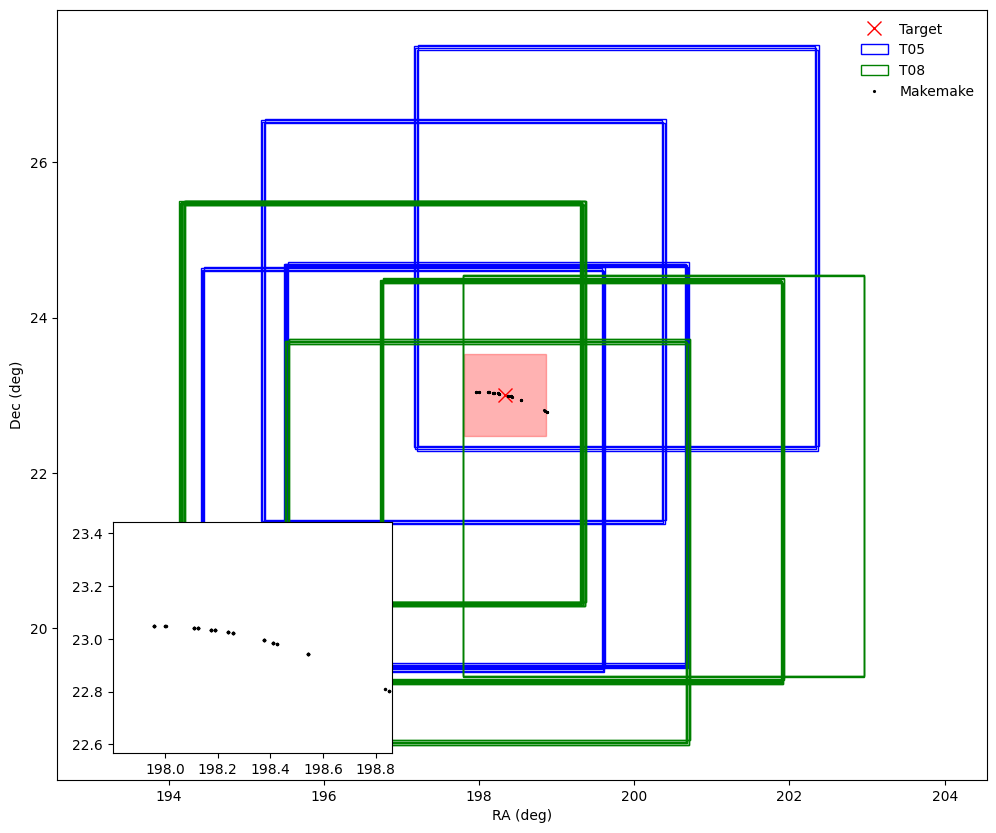

In [194]:
plot_frames_and_crop_area(filtered_df, center_ra_str, center_dec_str, crop_area_px, ast_pos)

In [195]:
# Create filepath list
red_path = '/atlas/red/'
diff_path = '/atlas/diff/'

im_list = []
for file in filtered_df.expname:
    tel  = file[:3]
    nn = file[3:8]
    im_list.append(os.path.join(red_path, f'{tel}/{nn}/{file}.fits.fz'))
    im_list.append(os.path.join(diff_path, f'{tel}/{nn}/{file}.diff.fz'))


for f in im_list:
    print(f)



/atlas/red/01a/59651/01a59651o0572o.fits.fz
/atlas/diff/01a/59651/01a59651o0572o.diff.fz
/atlas/red/01a/59651/01a59651o0576o.fits.fz
/atlas/diff/01a/59651/01a59651o0576o.diff.fz
/atlas/red/01a/59651/01a59651o0601o.fits.fz
/atlas/diff/01a/59651/01a59651o0601o.diff.fz
/atlas/red/01a/59651/01a59651o0612o.fits.fz
/atlas/diff/01a/59651/01a59651o0612o.diff.fz
/atlas/red/01a/59672/01a59672o0395o.fits.fz
/atlas/diff/01a/59672/01a59672o0395o.diff.fz
/atlas/red/01a/59672/01a59672o0399o.fits.fz
/atlas/diff/01a/59672/01a59672o0399o.diff.fz
/atlas/red/01a/59672/01a59672o0407o.fits.fz
/atlas/diff/01a/59672/01a59672o0407o.diff.fz
/atlas/red/01a/59672/01a59672o0423o.fits.fz
/atlas/diff/01a/59672/01a59672o0423o.diff.fz
/atlas/red/01a/59679/01a59679o0204o.fits.fz
/atlas/diff/01a/59679/01a59679o0204o.diff.fz
/atlas/red/01a/59679/01a59679o0231o.fits.fz
/atlas/diff/01a/59679/01a59679o0231o.diff.fz
/atlas/red/01a/59680/01a59680o0330o.fits.fz
/atlas/diff/01a/59680/01a59680o0330o.diff.fz
/atlas/red/01a/59680/

In [348]:
im_list_split

[['/atlas/red/01a/59666/01a59666o0018o.fits.fz',
  '/atlas/diff/01a/59666/01a59666o0018o.diff.fz',
  '/atlas/red/01a/59666/01a59666o0025o.fits.fz',
  '/atlas/diff/01a/59666/01a59666o0025o.diff.fz',
  '/atlas/red/01a/59666/01a59666o0037o.fits.fz'],
 ['/atlas/diff/01a/59666/01a59666o0037o.diff.fz',
  '/atlas/red/01a/59666/01a59666o0065o.fits.fz',
  '/atlas/diff/01a/59666/01a59666o0065o.diff.fz',
  '/atlas/red/01a/59670/01a59670o0075o.fits.fz',
  '/atlas/diff/01a/59670/01a59670o0075o.diff.fz'],
 ['/atlas/red/01a/59670/01a59670o0079o.fits.fz',
  '/atlas/diff/01a/59670/01a59670o0079o.diff.fz',
  '/atlas/red/01a/59670/01a59670o0092o.fits.fz',
  '/atlas/diff/01a/59670/01a59670o0092o.diff.fz',
  '/atlas/red/01a/59670/01a59670o0124o.fits.fz'],
 ['/atlas/diff/01a/59670/01a59670o0124o.diff.fz',
  '/atlas/red/01a/59683/01a59683o0276o.fits.fz',
  '/atlas/diff/01a/59683/01a59683o0276o.diff.fz',
  '/atlas/red/01a/59683/01a59683o0287o.fits.fz',
  '/atlas/diff/01a/59683/01a59683o0287o.diff.fz'],
 ['/at

In [341]:
import ast

In [ ]:
import os
import paramiko
from scp import SCPClient
import sys

# Get list of files to download and folder name when running .py
folder_name = sys.argv[1]
file_path = sys.argv[2]
with open(file_path, 'r') as file:
    remote_file_paths = [line.strip() for line in file]

def transfer_files(source_host, source_port, source_username, source_password, 
                   remote_file_paths, target_host, target_port, target_username, 
                   target_password, target_directory, remove_local_after_transfer=False):


    # Set up SFTP for source machine
    private_key = paramiko.RSAKey(filename=os.path.expanduser("~/.ssh/id_rsa"), password=source_password)
    source_transport = paramiko.Transport((source_host, source_port))
    source_transport.connect(username=source_username, pkey=private_key)
    sftp = paramiko.SFTPClient.from_transport(source_transport)
    
    # Set up SSH for target machine
    target_ssh = paramiko.SSHClient()
    target_ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    target_ssh.connect(target_host, target_port, username=target_username, password=target_password)
    stdin, stdout, stderr = target_ssh.exec_command(f"if [ ! -d '{target_directory}' ]; then mkdir -p {target_directory}; fi")
    stdout.channel.recv_exit_status()  # Wait for the command to finish
    scp = SCPClient(target_ssh.get_transport())

    i = 1
    for remote_path in remote_file_paths:
        local_file = os.path.basename(remote_path)
        try:
            # Download from source
            sftp.get(remote_path, local_file)
            
            # Upload to target
            scp.put(local_file, os.path.join(target_directory, local_file))

            # Optionally remove local file after transfer
            if remove_local_after_transfer:
                os.remove(local_file)
            print(f"(%i/%i) %s" % (i, len(remote_file_paths), remote_path), end="\r")

        except Exception as e:
            print(f"Error transferring {remote_path}: {e}")
        i += 1

    # Close connections
    sftp.close()
    source_transport.close()
    scp.close()
    target_ssh.close()


# Parameters for source and target machines
source_host = os.environ['ATLAS_HOST']
source_port = 22
source_username = os.environ['ATLAS_USER']
source_password = os.environ['ATLAS_PASS']
local_temp_directory = "~/atlas_files"

target_host = os.environ['VAST_HOST']
target_port = 22
target_username = os.environ['VAST_USER']
target_password = os.environ['VAST_PASS']
target_directory = "/mnt/vast/atlas-tdo/KBMOD/ori/%s" % folder_name

# Transfer files from source to target
transfer_files(source_host, source_port, source_username, source_password, 
               remote_file_paths, target_host, target_port, target_username, 
               target_password, target_directory, remove_local_after_transfer=True)


In [ ]:
import os
import paramiko
from scp import SCPClient
import sys
import concurrent.futures

# Get list of files to download and folder name when running .py
folder_name = sys.argv[1]
file_path = sys.argv[2]
with open(file_path, 'r') as file:
    remote_file_paths = [line.strip() for line in file]

def transfer_single_file(sftp, scp, target_directory, remote_path, remove_local_after_transfer):
    local_file = os.path.basename(remote_path)
    try:
        print(f"Attempting to download {remote_path}...")
        sftp.get(remote_path, local_file)
        print(f"Downloaded {remote_path} to {local_file}.")
        
        print(f"Attempting to upload {local_file} to {target_directory}...")
        scp.put(local_file, os.path.join(target_directory, local_file))
        print(f"Uploaded {local_file} to {target_directory}.")

        if remove_local_after_transfer:
            os.remove(local_file)
            print(f"Removed local file {local_file}.")

    except Exception as e:
        print(f"Error transferring {remote_path}: {e}")

def transfer_files(source_host, source_port, source_username, source_password, 
                   remote_file_paths, target_host, target_port, target_username, 
                   target_password, target_directory, remove_local_after_transfer=False):

    # Set up SFTP for source machine
    private_key = paramiko.RSAKey(filename=os.path.expanduser("~/.ssh/id_rsa"), password=source_password)
    source_transport = paramiko.Transport((source_host, source_port))
    source_transport.connect(username=source_username, pkey=private_key)
    sftp = paramiko.SFTPClient.from_transport(source_transport)
    
    # Set up SSH for target machine
    target_ssh = paramiko.SSHClient()
    target_ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    target_ssh.connect(target_host, target_port, username=target_username, password=target_password)
    stdin, stdout, stderr = target_ssh.exec_command(f"if [ ! -d '{target_directory}' ]; then mkdir -p {target_directory}; fi")
    stdout.channel.recv_exit_status()  # Wait for the command to finish
    scp = SCPClient(target_ssh.get_transport())

    # Using ThreadPoolExecutor to process multiple files concurrently
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(transfer_single_file, sftp, scp, target_directory, remote_path, remove_local_after_transfer) 
                   for remote_path in remote_file_paths]

        for i, future in enumerate(concurrent.futures.as_completed(futures), 1):
            future.result()  # wait for the task to complete
            print(f"(%i/%i) %s" % (i, len(remote_file_paths), remote_path), end="\r")

    # Close connections
    sftp.close()
    source_transport.close()
    scp.close()
    target_ssh.close()

# Parameters for source and target machines
source_host = os.environ['ATLAS_HOST']
source_port = 22
source_username = os.environ['ATLAS_USER']
source_password = os.environ['ATLAS_PASS']
local_temp_directory = "~/atlas_files"

target_host = os.environ['VAST_HOST']
target_port = 22
target_username = os.environ['VAST_USER']
target_password = os.environ['VAST_PASS']
target_directory = "/mnt/vast/atlas-tdo/KBMOD/ori/%s" % folder_name

# Transfer files from source to target
transfer_files(source_host, source_port, source_username, source_password, 
               remote_file_paths, target_host, target_port, target_username, 
               target_password, target_directory, remove_local_after_transfer=True)
